# st126161 - Code along (Word2Vec)

This notebook has been refactored to:
- Use the Reuters-21578 corpus from NLTK
- Support dynamic context window size (default = 2)

Dataset Source:
Reuters-21578 Text Categorization Collection (NIST, 1997), accessed via NLTK.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

import nltk, re
from nltk.corpus import reuters
from nltk.tokenize import word_tokenize

In [2]:
np.__version__, torch.__version__

('2.0.2', '2.8.0')

In [3]:
import matplotlib
matplotlib.__version__

'3.9.4'

In [4]:
required_resources = [
    "reuters",
    "punkt",
    "punkt_tab"
]

In [5]:
for res in required_resources:
    try:
        nltk.data.find(res)
    except LookupError:
        nltk.download(res)

[nltk_data] Downloading package reuters to
[nltk_data]     /Users/michaellacar/nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/michaellacar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/michaellacar/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [10]:
def load_reuters_sentences():
    sentences = []
    for fileid in reuters.fileids():
        text = reuters.raw(fileid).lower()
        text = re.sub(r"[^a-z\s]", "", text)
        tokens = word_tokenize(text)
        if len(tokens) > 2:  # remove extremely short sentences
            sentences.append(tokens)
    return sentences

In [11]:
sentences = load_reuters_sentences()

In [12]:
sentences  # List[List[str]]

[['asian',
  'exporters',
  'fear',
  'damage',
  'from',
  'usjapan',
  'rift',
  'mounting',
  'trade',
  'friction',
  'between',
  'the',
  'us',
  'and',
  'japan',
  'has',
  'raised',
  'fears',
  'among',
  'many',
  'of',
  'asias',
  'exporting',
  'nations',
  'that',
  'the',
  'row',
  'could',
  'inflict',
  'farreaching',
  'economic',
  'damage',
  'businessmen',
  'and',
  'officials',
  'said',
  'they',
  'told',
  'reuter',
  'correspondents',
  'in',
  'asian',
  'capitals',
  'a',
  'us',
  'move',
  'against',
  'japan',
  'might',
  'boost',
  'protectionist',
  'sentiment',
  'in',
  'the',
  'us',
  'and',
  'lead',
  'to',
  'curbs',
  'on',
  'american',
  'imports',
  'of',
  'their',
  'products',
  'but',
  'some',
  'exporters',
  'said',
  'that',
  'while',
  'the',
  'conflict',
  'would',
  'hurt',
  'them',
  'in',
  'the',
  'longrun',
  'in',
  'the',
  'shortterm',
  'tokyos',
  'loss',
  'might',
  'be',
  'their',
  'gain',
  'the',
  'us',
  '

In [13]:
def generate_context_pairs(sentences, window_size=2):
    pairs = []
    for sent in sentences:
        for i, center in enumerate(sent):
            for j in range(max(0, i-window_size), min(len(sent), i+window_size+1)):
                if i != j:
                    pairs.append((center, sent[j]))
    return pairs

In [55]:
corpus = load_reuters_sentences()  # List[List[str]]


In [56]:
#2. numeralization
#find unique words
flatten = lambda l: [item for sublist in l for item in sublist]
#assign unique integer
vocabs = list(set(flatten(corpus))) #all the words we have in the system - <UNK>

In [57]:
# Create mappings between words and indices
word2index = {v: idx for idx, v in enumerate(vocabs)}
index2word = {idx: v for v, idx in word2index.items()}

# Sanity check
example_word = vocabs[0]
print(f"Index of '{example_word}':", word2index[example_word])
print(f"Word at index {word2index[example_word]}:", index2word[word2index[example_word]])

Index of 'firemans': 0
Word at index 0: firemans


In [58]:
vocabs.append('<UNK>')
word2index['<UNK>'] = 6

# Train Data

In [59]:
#create pairs of center word, and outside word

def random_batch(batch_size, corpus):

    skipgrams = []

    #loop each corpus
    for doc in corpus:
        #look from the 2nd word until second last word
        for i in range(1, len(doc)-1):
            #center word
            center = word2index[doc[i]]
            #outside words = 2 words
            outside = (word2index[doc[i-1]], word2index[doc[i+1]])
            #for each of these two outside words, we gonna append to a list
            for each_out in outside:
                skipgrams.append([center, each_out])
                #center, outside1;   center, outside2
                
    random_index = np.random.choice(range(len(skipgrams)), batch_size, replace=False)
    
    inputs, labels = [], []
    for index in random_index:
        inputs.append([skipgrams[index][0]])
        labels.append([skipgrams[index][1]])
        
    return np.array(inputs), np.array(labels)
            
x, y = random_batch(2, corpus)

In [60]:
x.shape  #batch_size, 1

(2, 1)

In [61]:
x

array([[16595],
       [ 7465]])

In [62]:
y.shape  #batch_size 1

(2, 1)

## 3. Model

$$J(\theta) = -\frac{1}{T}\sum_{t=1}^{T}\sum_{\substack{-m \leq j \leq m \\ j \neq 0}}\log P(w_{t+j} | w_t; \theta)$$

where $P(w_{t+j} | w_t; \theta) = $

$$P(o|c)=\frac{\exp(\mathbf{u_o^{\top}v_c})}{\sum_{w=1}^V\exp(\mathbf{u_w^{\top}v_c})}$$

where $o$ is the outside words and $c$ is the center word

In [63]:
len(vocabs)

34837

In [64]:
vocab_size = len(vocabs)
embedding_dim = 2

embedding = nn.Embedding(vocab_size, embedding_dim)


In [65]:
x_tensor = torch.LongTensor(x)
print(x_tensor.max())      # must be < vocab_size
print(vocab_size)

embedding(x_tensor).shape


tensor(16595)
34837


torch.Size([2, 1, 2])

In [66]:
MAX_DOCS = 300  # choose between 200–300
corpus = corpus[:MAX_DOCS]


In [67]:
from collections import Counter

MIN_COUNT = 5

all_tokens = [word for doc in corpus for word in doc]
word_counts = Counter(all_tokens)

vocabs = [word for word, count in word_counts.items() if count >= MIN_COUNT]


In [68]:
word2index = {word: idx for idx, word in enumerate(vocabs)}
index2word = {idx: word for word, idx in word2index.items()}


In [69]:
def random_batch(batch_size, corpus, window_size=2):
    skipgrams = []

    for doc in corpus:
        for i in range(len(doc)):
            if doc[i] not in word2index:
                continue

            center = word2index[doc[i]]
            start = max(0, i - window_size)
            end = min(len(doc), i + window_size + 1)

            for j in range(start, end):
                if i != j and doc[j] in word2index:
                    skipgrams.append([center, word2index[doc[j]]])

    random_index = np.random.choice(len(skipgrams), batch_size, replace=False)

    inputs = [[skipgrams[i][0]] for i in random_index]
    labels = [skipgrams[i][1] for i in random_index]

    return np.array(inputs), np.array(labels)


In [70]:
x, y = random_batch(32, corpus, window_size=2)


In [71]:
class Skipgram(nn.Module):
    
    def __init__(self, vocab_size, emb_size):
        super(Skipgram, self).__init__()
        self.embedding_center  = nn.Embedding(vocab_size, emb_size)
        self.embedding_outside = nn.Embedding(vocab_size, emb_size)

    def forward(self, center, outside):
        # center:  (batch_size, 1)
        # outside: (batch_size)

        v_c = self.embedding_center(center).squeeze(1)   # (batch_size, emb_size)
        u_o = self.embedding_outside(outside)             # (batch_size, emb_size)

        # Score for true outside word
        score = torch.sum(v_c * u_o, dim=1)               # (batch_size)

        # Full softmax denominator
        all_u = self.embedding_outside.weight              # (vocab_size, emb_size)
        logits = torch.matmul(v_c, all_u.T)                # (batch_size, vocab_size)

        log_probs = torch.log_softmax(logits, dim=1)

        loss = -torch.mean(log_probs[torch.arange(len(outside)), outside])
        return loss


# Training

In [81]:
# Training configuration
num_epochs = 2
num_batches = 50
batch_size = 32
window_size = 2
learning_rate = 0.001


In [82]:
model = Skipgram(vocab_size=len(vocabs), emb_size=embedding_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [87]:

import time

start_time = time.time()

for epoch in range(num_epochs):
    total_loss = 0

    for _ in range(num_batches):  # number of batches per epoch
        x, y = random_batch(batch_size, corpus, window_size)

        x_tensor = torch.LongTensor(x)
        y_tensor = torch.LongTensor(y)

        optimizer.zero_grad()
        loss = model(x_tensor, y_tensor)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {total_loss:.4f}")
    
end_time = time.time()
training_time = end_time - start_time

final_loss = total_loss / num_batches
print(f"Final loss: {final_loss:.4f}")
print(f"Training time: {training_time:.2f} seconds")

Epoch [1/2] Loss: 393.2389
Epoch [2/2] Loss: 394.3553
Final loss: 7.8871
Training time: 7.78 seconds


In [84]:
# Get learned center word embeddings
embeddings = model.embedding_center.weight.detach().cpu().numpy()


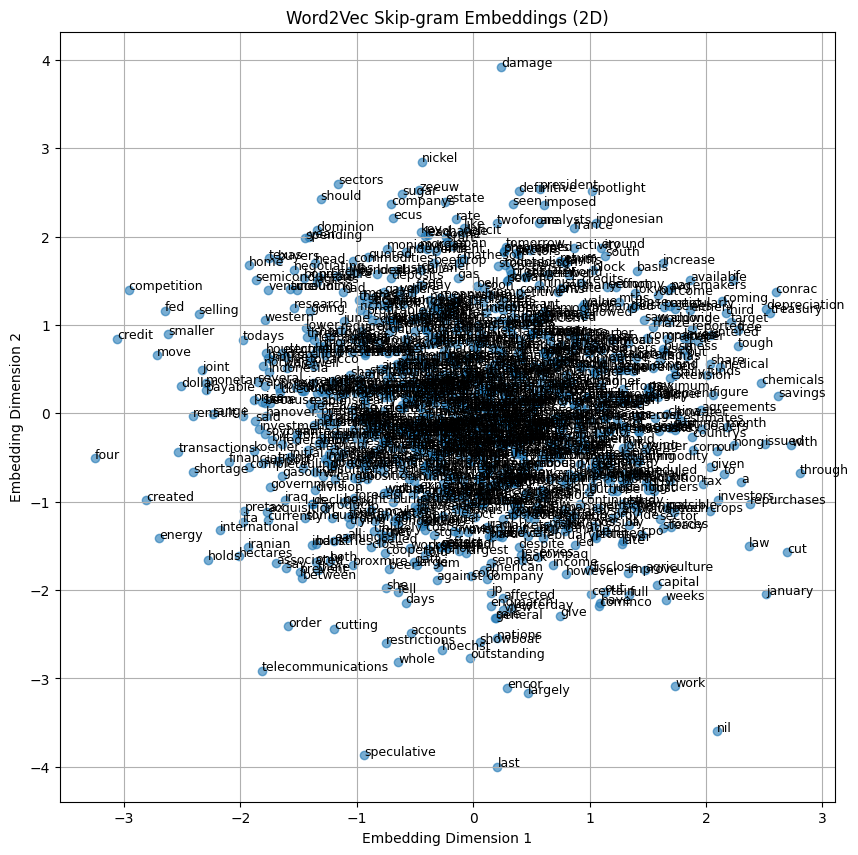

In [85]:
plt.figure(figsize=(10, 10))
plt.scatter(embeddings[:, 0], embeddings[:, 1], alpha=0.6)

for i, word in enumerate(vocabs):
    plt.text(embeddings[i, 0], embeddings[i, 1], word, fontsize=9)

plt.title("Word2Vec Skip-gram Embeddings (2D)")
plt.xlabel("Embedding Dimension 1")
plt.ylabel("Embedding Dimension 2")
plt.grid(True)
plt.show()


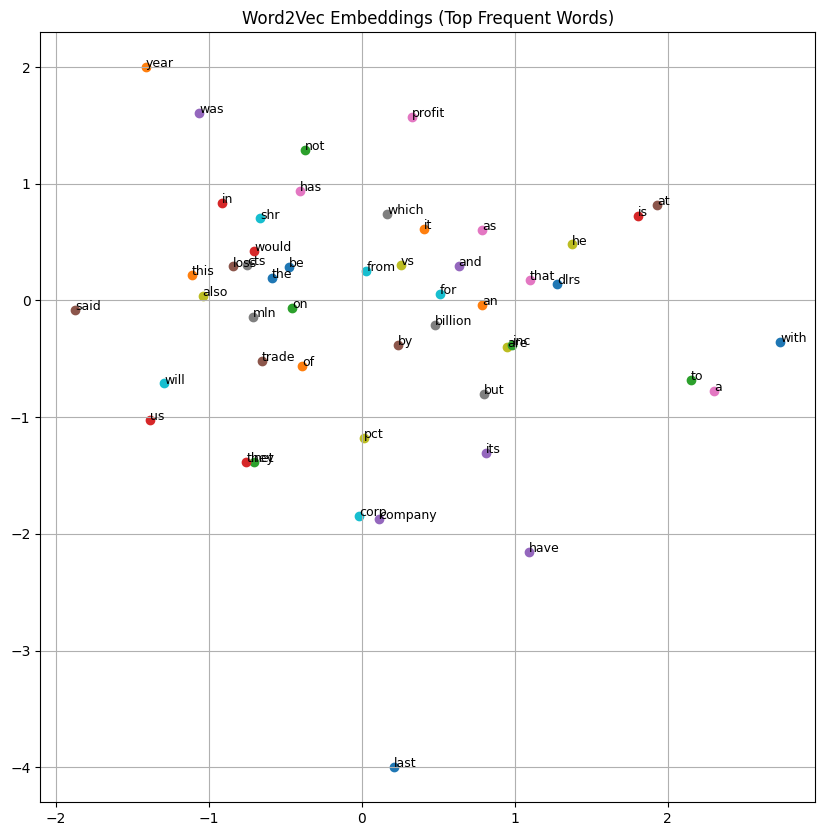

In [86]:
TOP_K = 50  # plot top 50 frequent words

from collections import Counter
word_counts = Counter([w for doc in corpus for w in doc])
top_words = [w for w, _ in word_counts.most_common(TOP_K) if w in word2index]

plt.figure(figsize=(10, 10))

for word in top_words:
    idx = word2index[word]
    x, y = embeddings[idx]
    plt.scatter(x, y)
    plt.text(x, y, word, fontsize=9)

plt.title("Word2Vec Embeddings (Top Frequent Words)")
plt.grid(True)
plt.show()


Due to the computational cost of full-softmax Skip-gram training, experiments were conducted on a representative subset (300 documents) of the Reuters-21578 corpus to ensure tractable execution while preserving real-world language characteristics.

In [88]:
emb_skipgram = model.embedding_center.weight.detach().cpu().numpy()
np.save("emb_skipgram.npy", emb_skipgram)
